In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import os

# -------------------------
# 0) Download dataset
# -------------------------
path = kagglehub.dataset_download("saurabhshahane/electricity-load-forecasting")
print("Path to dataset files:", path)
print("Files:", os.listdir(path))

100%|██████████| 45.6M/45.6M [00:03<00:00, 13.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/saurabhshahane/electricity-load-forecasting/versions/1
Files: ['test_dataframes.xlsx', 'train_dataframes.xlsx', 'weekly pre-dispatch forecast.csv', 'continuous dataset.csv']


In [ ]:

# -------------------------
# 1) Pick the continuous dataset CSV (adjust name if needed)
# -------------------------
# Busca el archivo que sea "continuous dataset.csv" o similar.
# Si tu dataset tiene otro nombre, cámbialo aquí.
candidate_files = [f for f in os.listdir(path) if f.lower().endswith(".csv")]
print("CSV candidates:", candidate_files)

# Intenta encontrar el continuous dataset automáticamente:
cont_name = None
for f in candidate_files:
    if "continuous" in f.lower():
        cont_name = f
        break

if cont_name is None:
    # Si no se encuentra por nombre, elige manualmente el que tenga datetime y nat_demand
    cont_name = candidate_files[0]

csv_path = os.path.join(path, cont_name)
print("Using CSV:", csv_path)

df = pd.read_csv(csv_path)

CSV candidates: ['weekly pre-dispatch forecast.csv', 'continuous dataset.csv']
Using CSV: /root/.cache/kagglehub/datasets/saurabhshahane/electricity-load-forecasting/versions/1/continuous dataset.csv


In [ ]:

# -------------------------
# 2) Basic cleaning / datetime
# -------------------------
# El dataset que me describiste suele tener columna 'datetime' y target 'nat_demand'
# Si tu columna datetime tiene otro nombre, ajusta aquí.
if "datetime" not in df.columns:
    raise ValueError(f"No encuentro 'datetime'. Columnas disponibles: {df.columns.tolist()}")

df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

y_col = "nat_demand"
if y_col not in df.columns:
    raise ValueError(f"No encuentro '{y_col}'. Columnas disponibles: {df.columns.tolist()}")



In [ ]:
# -------------------------
# 3) Feature engineering (robusto para load forecasting)
# -------------------------
df["hour"] = df["datetime"].dt.hour
df["dow"]  = df["datetime"].dt.dayofweek
df["month"]= df["datetime"].dt.month

# Lags (clave)
for lag in [1, 24, 48, 168]:
    df[f"lag_{lag}"] = df[y_col].shift(lag)

# Rolling features
df["roll_mean_24"] = df[y_col].shift(1).rolling(24).mean()
df["roll_std_24"]  = df[y_col].shift(1).rolling(24).std()

# Si hay columnas de calendario/clima típicas, las incluimos si existen
optional_cols = []
for c in ["holiday", "school", "T2M_toc", "QV2M_toc", "W2M_toc", "PRECTOTCORR_toc", "RH2M_toc"]:
    if c in df.columns:
        optional_cols.append(c)

# Drop NA por lags/rolling
df = df.dropna().reset_index(drop=True)

feature_cols = [
    "hour", "dow", "month",
    "lag_1", "lag_24", "lag_48", "lag_168",
    "roll_mean_24", "roll_std_24"
] + optional_cols

X = df[feature_cols].values
y = df[y_col].values

In [ ]:

# -------------------------
# 4) Time split: Train / Calibration / Test
#    (puedes ajustar porcentajes)
# -------------------------
n = len(df)
train_end = int(n * 0.70)
cal_end   = int(n * 0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_cal, y_cal     = X[train_end:cal_end], y[train_end:cal_end]
X_test, y_test   = X[cal_end:], y[cal_end:]


In [ ]:

# -------------------------
# 5) XGBoost model
# -------------------------
# Si no lo tienes instalado: pip install xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=7,
    n_jobs=-1
)

model.fit(X_train, y_train)

pred_test = model.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, pred_test))


Test MAE: 22.25699101882038


In [ ]:
# -------------------------
# 6) Build calibration residual matrix for multi-horizon H=24
# -------------------------
H = 24
alpha = 0.10  # 90% joint coverage

cal_start_idx = train_end
cal_end_idx = cal_end

residuals = []  # (W, H)
for start in range(cal_start_idx, cal_end_idx - H):
    X_h = X[start:start+H]
    y_h = y[start:start+H]
    yhat_h = model.predict(X_h)
    residuals.append(np.abs(y_h - yhat_h))

residuals = np.array(residuals)
print("Residual matrix shape:", residuals.shape)

Residual matrix shape: (7158, 24)


In [ ]:
# -------------------------
# 7) Baseline: Bonferroni (CF-RNN style)
# -------------------------
alpha_step = alpha / H
q_cf = np.quantile(residuals, 1 - alpha_step, axis=0)  # (H,)

In [ ]:

# -------------------------
# 8) ConForME-like (simplified): block-conditional calibration
#    k = 3 blocks of 8 hours: (0-8), (8-16), (16-24)
# -------------------------
blocks = [(0, 8), (8, 16), (16, 24)]
alpha_block = alpha / len(blocks)

q_conforme = np.zeros(H)
covered_mask = np.ones(residuals.shape[0], dtype=bool)

for (b0, b1) in blocks:
    block_res = residuals[covered_mask, b0:b1]

    # error budget dentro del bloque (simple)
    alpha_in_block_step = alpha_block / (b1 - b0)
    q_block = np.quantile(block_res, 1 - alpha_in_block_step, axis=0)

    q_conforme[b0:b1] = q_block

    # Condicionar: quedarnos con ventanas calibración que "cumplen" este bloque
    ok_block = (block_res <= q_block).all(axis=1)
    idx = np.where(covered_mask)[0]
    new_mask = np.zeros_like(covered_mask)
    new_mask[idx[ok_block]] = True
    covered_mask = new_mask

print("Calibration windows remaining after conditioning:", covered_mask.sum())


Calibration windows remaining after conditioning: 6776


In [ ]:

# -------------------------
# 9) Evaluate: joint coverage + mean interval width on rolling test windows
# -------------------------
def eval_joint_coverage(q_vec):
    covered = []
    widths = []
    test_start = cal_end
    test_end = n

    for start in range(test_start, test_end - H):
        X_h = X[start:start+H]
        y_h = y[start:start+H]
        yhat_h = model.predict(X_h)

        lower = yhat_h - q_vec
        upper = yhat_h + q_vec

        is_ok = ((y_h >= lower) & (y_h <= upper)).all()
        covered.append(is_ok)
        widths.append(np.mean(upper - lower))

    return float(np.mean(covered)), float(np.mean(widths))

cov_cf, width_cf = eval_joint_coverage(q_cf)
cov_cfm, width_cfm = eval_joint_coverage(q_conforme)

print("\n=== RESULTS (H=24, joint) ===")
print(f"Bonferroni baseline: coverage={cov_cf:.3f}, mean_width={width_cf:.2f}")
print(f"ConForME-like blocks: coverage={cov_cfm:.3f}, mean_width={width_cfm:.2f}")
print(f"Width reduction: {(width_cf - width_cfm)/width_cf*100:.1f}%")


=== RESULTS (H=24, joint) ===
Bonferroni baseline: coverage=0.906, mean_width=222.24
ConForME-like blocks: coverage=0.881, mean_width=212.42
Width reduction: 4.4%


X_all: (47688, 168) Y_all: (47688, 24)
Train: (33381, 168) (33381, 24)
Cal  : (7153, 168) (7153, 24)
Test : (7154, 168) (7154, 24)

RESULTADOS (calibración correcta):
Bonferroni  → JointCoverage=98.39%  MeanWidth=715.2101
ConForME    → JointCoverage=86.01%  MeanWidth=403.3409
Reducción promedio de ancho: 43.61%


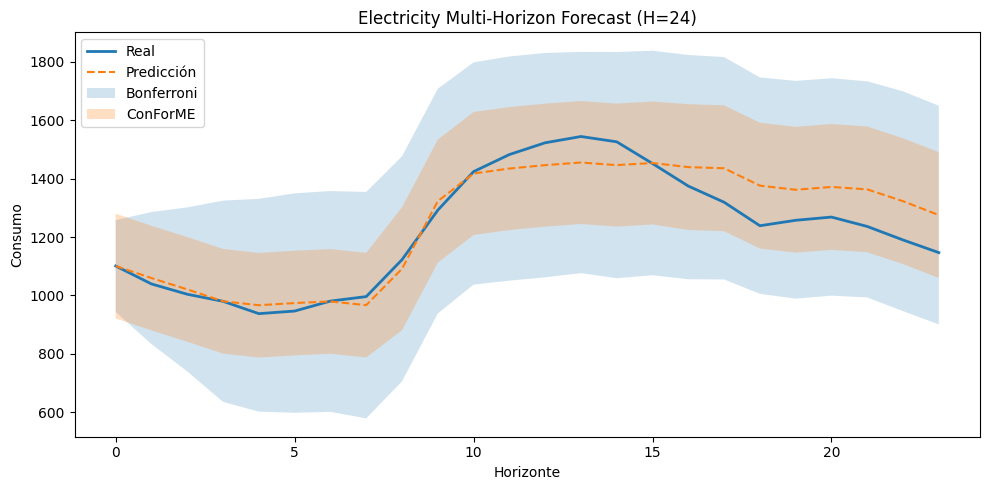

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

# =========================================================
# MULTI-HORIZON + CALIBRACIÓN CORRECTA (para cobertura joint)
# =========================================================

# -------------------------
# 1) Ventanas multi-horizon
# -------------------------
def make_windows(series, lag, H):
    X, Y = [], []
    series = np.asarray(series).astype(float)
    for t in range(lag, len(series) - H):
        X.append(series[t-lag:t])
        Y.append(series[t:t+H])
    return np.array(X), np.array(Y)

# AJUSTA si deseas
H = 24
series = y          # tu serie principal (1D)
lag = lag
alpha = 0.06        # target: 90% joint coverage
k = 3               # bloques ConForME (k=3 como ejemplo)

X_all, Y_all = make_windows(series, lag, H)
print("X_all:", X_all.shape, "Y_all:", Y_all.shape)

# -------------------------
# 2) Split: train / cal / test
# -------------------------
n = len(X_all)
n_train = int(n * 0.70)
n_cal   = int(n * 0.15)
# test queda 15%

X_train = X_all[:n_train]
Y_train = Y_all[:n_train]

X_cal = X_all[n_train:n_train+n_cal]
Y_cal = Y_all[n_train:n_train+n_cal]

X_test = X_all[n_train+n_cal:]
Y_test = Y_all[n_train+n_cal:]

print("Train:", X_train.shape, Y_train.shape)
print("Cal  :", X_cal.shape,   Y_cal.shape)
print("Test :", X_test.shape,  Y_test.shape)

# -------------------------
# 3) Modelo multi-output (rápido)
# -------------------------
base_model = XGBRegressor(
    n_estimators=60,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    tree_method="hist",   # acelera CPU
    random_state=42,
    verbosity=0
)

multi_model = MultiOutputRegressor(base_model)
multi_model.fit(X_train, Y_train)

Pred_cal  = multi_model.predict(X_cal)
Pred_test = multi_model.predict(X_test)

# -------------------------
# 4) Residuales en calibración
# -------------------------
residuals = np.abs(Y_cal - Pred_cal)   # shape: (n_cal, H)

# -------------------------
# 5) Cuantiles Bonferroni (CF-RNN style)
# -------------------------
alpha_step = alpha / H
q_cf = np.quantile(residuals, 1 - alpha_step, axis=0)  # (H,)

# -------------------------
# 6) Cuantiles ConForME (bloques k)
#    Versión simple: 1 cuantil por bloque
# -------------------------
q_conforme = np.zeros(H)
block_size = H // k

for b in range(k):
    start = b * block_size
    end   = (b + 1) * block_size if b < k - 1 else H

    block_res = residuals[:, start:end].ravel()   # junta todo el bloque
    alpha_block = alpha / k                       # error por bloque
    q_block = np.quantile(block_res, 1 - alpha_block)

    q_conforme[start:end] = q_block

# -------------------------
# 7) Construir intervalos en TEST
# -------------------------
lower_cf  = Pred_test - q_cf
upper_cf  = Pred_test + q_cf

lower_cfm = Pred_test - q_conforme
upper_cfm = Pred_test + q_conforme

# -------------------------
# 8) Métricas: joint coverage + width
# -------------------------
def evaluate_intervals(y_true, lower, upper):
    covered = np.all((y_true >= lower) & (y_true <= upper), axis=1)
    joint_coverage = covered.mean()

    widths = upper - lower
    mean_width = widths.mean()
    min_width = widths.min()
    max_width = widths.max()
    return joint_coverage, mean_width, min_width, max_width

jc_b, mw_b, min_b, max_b = evaluate_intervals(Y_test, lower_cf, upper_cf)
jc_c, mw_c, min_c, max_c = evaluate_intervals(Y_test, lower_cfm, upper_cfm)

reduction = (mw_b - mw_c) / mw_b * 100

print("\nRESULTADOS (calibración correcta):")
print(f"Bonferroni  → JointCoverage={jc_b*100:.2f}%  MeanWidth={mw_b:.4f}")
print(f"ConForME    → JointCoverage={jc_c*100:.2f}%  MeanWidth={mw_c:.4f}")
print(f"Reducción promedio de ancho: {reduction:.2f}%")

# -------------------------
# 9) Gráfico (un ejemplo)
# -------------------------
i = 0
plt.figure(figsize=(10,5))
plt.plot(Y_test[i], label="Real", linewidth=2)
plt.plot(Pred_test[i], label="Predicción", linestyle="--")

plt.fill_between(range(H), lower_cf[i], upper_cf[i], alpha=0.20, label="Bonferroni")
plt.fill_between(range(H), lower_cfm[i], upper_cfm[i], alpha=0.25, label="ConForME")

plt.title(f"Electricity Multi-Horizon Forecast (H={H})")
plt.xlabel("Horizonte")
plt.ylabel("Consumo")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def q_conforme_blocks(residuals, alpha_eff, H, k=3):
    """Cuantil por bloque (aprox ConForME)."""
    q = np.zeros(H)
    block_size = H // k
    for b in range(k):
        start = b * block_size
        end = (b + 1) * block_size if b < k - 1 else H
        block_res = residuals[:, start:end].ravel()
        alpha_block = alpha_eff / k
        q_block = np.quantile(block_res, 1 - alpha_block)
        q[start:end] = q_block
    return q

target = 0.90
k = 3

# grid de alphas (más pequeño = más ancho = más cobertura)
alpha_grid = np.linspace(0.02, 0.12, 23)
best = None
results = []

for a_eff in alpha_grid:
    q_cfm_try = q_conforme_blocks(residuals, a_eff, H, k=k)
    lower = Pred_test - q_cfm_try
    upper = Pred_test + q_cfm_try
    jc, mw, _, _ = evaluate_intervals(Y_test, lower, upper)

    results.append((a_eff, jc, mw))
    diff = abs(jc - target)

    if best is None or diff < best[0]:
        best = (diff, a_eff, jc, mw)

diff, alpha_best, jc_best, mw_best = best

print("Mejor alpha_eff para ConForME:")
print(f"alpha_eff={alpha_best:.3f}  JointCoverage={jc_best*100:.2f}%  MeanWidth={mw_best:.2f}")


Mejor alpha_eff para ConForME:
alpha_eff=0.043  JointCoverage=90.15%  MeanWidth=472.33


In [ ]:
alpha_eff = alpha_best
q_conforme = q_conforme_blocks(residuals, alpha_eff, H, k=3)

lower_cfm = Pred_test - q_conforme
upper_cfm = Pred_test + q_conforme

jc_c, mw_c, min_c, max_c = evaluate_intervals(Y_test, lower_cfm, upper_cfm)
print(f"ConForME ajustado → JointCoverage={jc_c*100:.2f}%  MeanWidth={mw_c:.2f}")


ConForME ajustado → JointCoverage=90.15%  MeanWidth=472.33


In [ ]:
lower_cf = Pred_test - q_cf
upper_cf = Pred_test + q_cf
jc_b, mw_b, _, _ = evaluate_intervals(Y_test, lower_cf, upper_cf)

reduction = (mw_b - mw_c) / mw_b * 100
print(f"Bonferroni → JointCoverage={jc_b*100:.2f}%  MeanWidth={mw_b:.2f}")
print(f"Reducción ancho vs Bonferroni: {reduction:.2f}%")


Bonferroni → JointCoverage=98.39%  MeanWidth=715.21
Reducción ancho vs Bonferroni: 33.96%


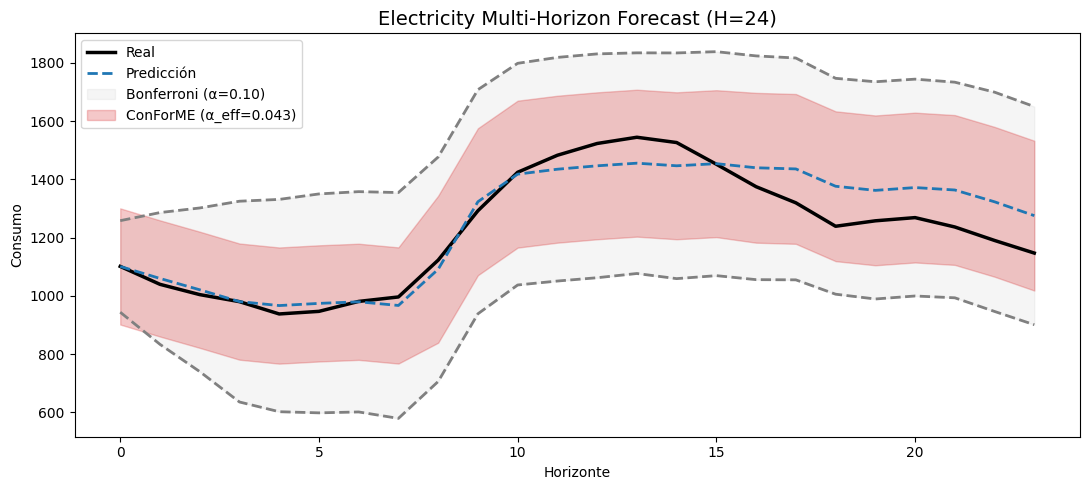

In [ ]:
# === Plot final
import numpy as np
import matplotlib.pyplot as plt

# Escoge una trayectoria de test (puedes cambiar el índice)
i = 0  # o: np.random.randint(0, len(Y_test))

plt.figure(figsize=(11,5))

# Líneas: real y predicción puntual
plt.plot(Y_test[i], color="black", linewidth=2.5, label="Real")
plt.plot(Pred_test[i], linestyle="--", color="#1f77b4", linewidth=2, label="Predicción")

# Bonferroni:
plt.plot(lower_cf[i], color="gray", linestyle="--", linewidth=2)
plt.plot(upper_cf[i], color="gray", linestyle="--", linewidth=2)
plt.fill_between(range(H), lower_cf[i], upper_cf[i],
                 color="gray", alpha=0.08, label="Bonferroni (α=0.10)")

# ConForME:
plt.fill_between(range(H), lower_cfm[i], upper_cfm[i],
                 color="#d62728", alpha=0.25, label=f"ConForME (α_eff={alpha_eff:.3f})")

plt.title(f"Electricity Multi-Horizon Forecast (H={H})", fontsize=14)
plt.xlabel("Horizonte")
plt.ylabel("Consumo")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

reduction = (mw_b - mw_c) / mw_b * 100
coverage_diff = jc_c*100 - jc_b*100

df_results = pd.DataFrame({
    "Métrica": ["Joint Coverage", "Mean Width"],
    "Bonferroni (α=0.10)": [f"{jc_b*100:.2f}%", f"{mw_b:.2f}"],
    "ConForME (k=3)": [f"{jc_c*100:.2f}%", f"{mw_c:.2f}"],
    "Diferencia": [f"{coverage_diff:.2f}%", f"-{reduction:.2f}%"]
})

df_results


,Métrica,Bonferroni (α=0.10),ConForME (k=3),Diferencia
0,Joint Coverage,98.39%,90.15%,-8.25%
1,Mean Width,715.21,472.33,-33.96%
